# Nearest neighbor analysis

- Nearest neighbors
- Nearest within a radius
- K-Nearest Neighbors

Using
- `.sjoin_nearest()`

# Point to Point Nearest Neighbor

Search for the closest public transporation stop for each building.

- uses a spatial index `STRTree`, an implementation of `R-tree`
- implemented in `shapely` and used under the hood

1. Import and visualize data
2. Match/convert CRS
3. Use `.sjoin_nearest()` to find closest stop
4. Check for duplicates (more than one closest) and handle accordingly
5. Consider adding a search radius
6. Optionally draw lines between buildings and nearest stops
7. Visualize and compute statistics

In [1]:
%matplotlib inline
import geopandas as gpd 
import matplotlib.pyplot as plt 

stops = gpd.read_file("data/ch6/Helsinki/pt_stops_helsinki.gpkg")
building_points = gpd.read_file("data/ch6/Helsinki/building_points_helsinki.zip")

print(f"Number of stops: {len(stops)}")
print(stops[:2])

Number of stops: 8377
     stop_name  stop_lat  stop_lon  stop_id                   geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (24.95657 60.17127)


In [2]:
print(f"Number of buildings: {len(building_points)}")
print(building_points[:2])

Number of buildings: 158731
          name                   geometry
0         None  POINT (24.85584 60.20727)
1  Uimastadion  POINT (24.93045 60.18882)


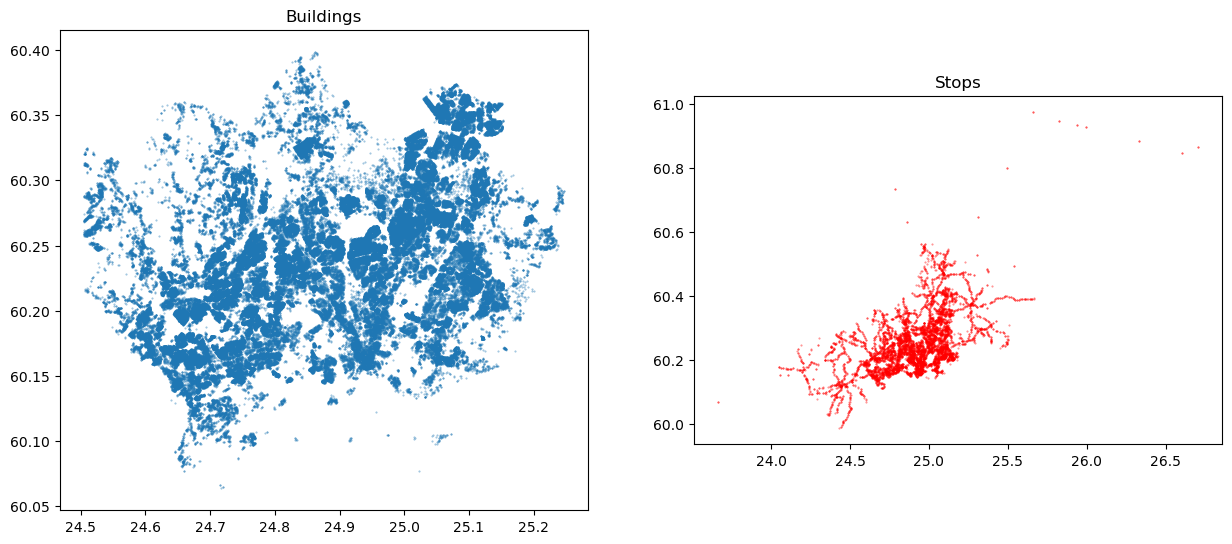

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

building_points.plot(ax=ax1, markersize=0.2, alpha=0.5)
ax1.set_title("Buildings")
stops.plot(ax=ax2, markersize=0.2, alpha=0.5, color="red")
ax2.set_title("Stops");

In [4]:
stops = stops.to_crs(3067)
building_points = building_points.to_crs(3067)
print(stops[:2])

     stop_name  stop_lat  stop_lon  stop_id                        geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (386623.301 6672037.884)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (386623.991 6672239.572)


In [5]:
%time
closest = building_points.sjoin_nearest(stops, distance_col="distance")
print(closest[:5])

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.58 μs
             name                        geometry  index_right  \
0            None    POINT (381166.6 6676424.438)         1131   
1     Uimastadion  POINT (385236.565 6674238.472)          467   
2            None  POINT (386317.478 6672100.648)           61   
3  Hartwall Arena   POINT (385225.109 6676120.56)          532   
4           Talli  POINT (385079.733 6676989.745)          496   

          stop_name  stop_lat  stop_lon  stop_id    distance  
0        Muusantori  60.20749  24.85745  1304138   92.679893  
1  Auroran sairaala  60.19145  24.92554  1171122  400.243370  
2      Senaatintori  60.16901  24.95046  1020450  109.819633  
3         Veturitie  60.20661  24.92968  1174112  104.632434  
4           Posti 1  60.21345  24.91755  1172143  472.248282  


In [6]:
closest.shape

(159818, 8)

In [7]:
%time
closest_limited = building_points.sjoin_nearest(
    stops, max_distance=100, distance_col="distance"
)
print(closest_limited[:5])
print(closest_limited.shape)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.34 μs
    name                        geometry  index_right            stop_name  \
0   None    POINT (381166.6 6676424.438)         1131           Muusantori   
10  None  POINT (384645.078 6669763.917)          592  Hernesaaren laituri   
12  None  POINT (384782.782 6669707.017)          595  Hernesaaren laituri   
13  None   POINT (384714.47 6669710.887)          592  Hernesaaren laituri   
16  None  POINT (385040.806 6670639.517)          596      Hernesaarenkatu   

     stop_lat   stop_lon  stop_id   distance  
0   60.207490  24.857450  1304138  92.679893  
10  60.148287  24.923281  1204101  57.786201  
12  60.148680  24.924240  1204108  79.844881  
13  60.148287  24.923281  1204101  32.640335  
16  60.156110  24.930370  1204109  87.888087  
(40128, 8)


In [8]:
closest = closest.merge(
    stops[[stops.active_geometry_name]], 
    left_on="index_right", 
    right_index=True
)

In [9]:
print(closest[:5])
print(closest.columns)

             name                      geometry_x  index_right  \
0            None    POINT (381166.6 6676424.438)         1131   
1     Uimastadion  POINT (385236.565 6674238.472)          467   
2            None  POINT (386317.478 6672100.648)           61   
3  Hartwall Arena   POINT (385225.109 6676120.56)          532   
4           Talli  POINT (385079.733 6676989.745)          496   

          stop_name  stop_lat  stop_lon  stop_id    distance  \
0        Muusantori  60.20749  24.85745  1304138   92.679893   
1  Auroran sairaala  60.19145  24.92554  1171122  400.243370   
2      Senaatintori  60.16901  24.95046  1020450  109.819633   
3         Veturitie  60.20661  24.92968  1174112  104.632434   
4           Posti 1  60.21345  24.91755  1172143  472.248282   

                       geometry_y  
0   POINT (381256.66 6676446.317)  
1  POINT (384973.331 6674539.973)  
2   POINT (386277.25 6671998.462)  
3  POINT (385255.784 6676220.595)  
4  POINT (384607.679 6677003.267)  
In

> Create LineStrings
>
> `linestrings` requires an array, "geometry" contains POINTs, so must convert.

In [10]:
from shapely import linestrings

closest["geometry"] = linestrings(
    closest.geometry_x.get_coordinates().to_numpy(),
    closest.geometry_y.get_coordinates().to_numpy(),
)

In [11]:
closest = closest.set_geometry("geometry")
print(closest[:5])

             name                      geometry_x  index_right  \
0            None    POINT (381166.6 6676424.438)         1131   
1     Uimastadion  POINT (385236.565 6674238.472)          467   
2            None  POINT (386317.478 6672100.648)           61   
3  Hartwall Arena   POINT (385225.109 6676120.56)          532   
4           Talli  POINT (385079.733 6676989.745)          496   

          stop_name  stop_lat  stop_lon  stop_id    distance  \
0        Muusantori  60.20749  24.85745  1304138   92.679893   
1  Auroran sairaala  60.19145  24.92554  1171122  400.243370   
2      Senaatintori  60.16901  24.95046  1020450  109.819633   
3         Veturitie  60.20661  24.92968  1174112  104.632434   
4           Posti 1  60.21345  24.91755  1172143  472.248282   

                       geometry_y  \
0   POINT (381256.66 6676446.317)   
1  POINT (384973.331 6674539.973)   
2   POINT (386277.25 6671998.462)   
3  POINT (385255.784 6676220.595)   
4  POINT (384607.679 6677003.267)

In [12]:
print(closest.columns)

Index(['name', 'geometry_x', 'index_right', 'stop_name', 'stop_lat',
       'stop_lon', 'stop_id', 'distance', 'geometry_y', 'geometry'],
      dtype='object')


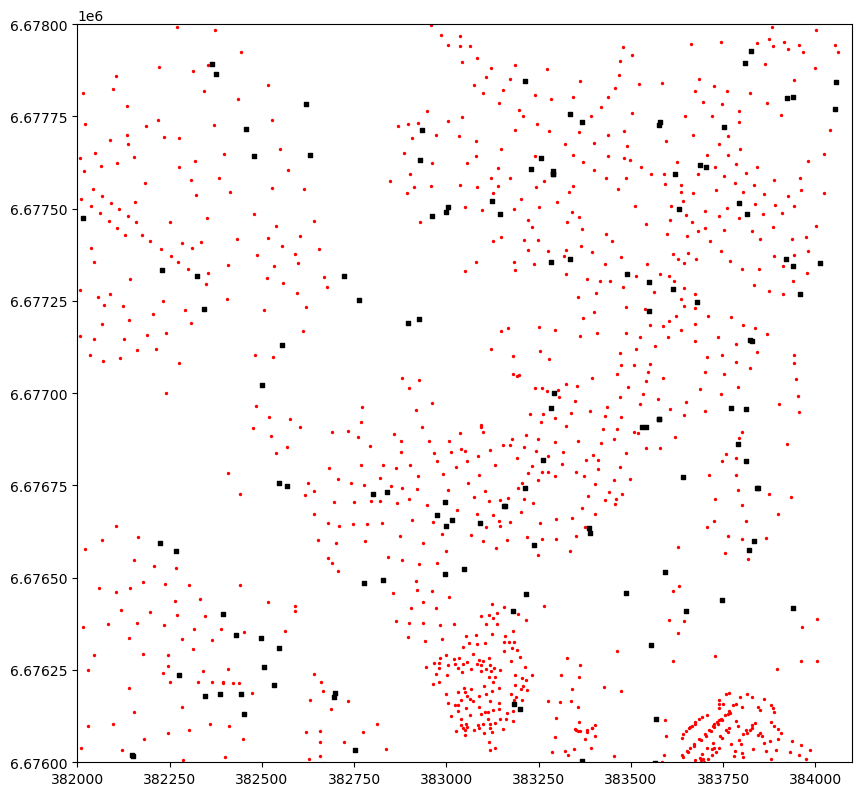

In [13]:
ax = closest.plot(lw=0.5, figsize=(10, 10))
ax = building_points.plot(ax=ax, color="red", markersize=2)
ax = stops.plot(ax=ax, color="black", markersize=8.5, marker="s")
# Zoom to specific area
ax.set_xlim(382000, 384100)
ax.set_ylim(6676000, 6678000);

>[!warning] connections do not render

In [14]:
closest["geometry"][:5]

0    LINESTRING (381166.6 381256.66, 6676424.438 66...
1    LINESTRING (385236.565 384973.331, 6674238.472...
2    LINESTRING (386317.478 386277.25, 6672100.648 ...
3    LINESTRING (385225.109 385255.784, 6676120.56 ...
4    LINESTRING (385079.733 384607.679, 6676989.745...
Name: geometry, dtype: geometry

In [15]:
closest["distance"].describe()

count    159818.000000
mean        229.029606
std         292.348698
min           0.743490
25%          99.771301
50%         163.805853
75%         260.461391
max        7698.270635
Name: distance, dtype: float64

In [16]:
closest.iloc[2].geometry == closest.iloc[1].geometry

False

## Nearest with Polygon and LineString

> Closest urban park to each building in Kamppi neighborhood

In [17]:
buildings = gpd.read_file("data/ch6/Helsinki/Kamppi_buildings.gpkg")
parks = gpd.read_file("data/ch6/Helsinki/Kamppi_parks.gpkg")
roads = gpd.read_file("data/ch6/Helsinki/Kamppi_roads.gpkg")
print(buildings[:5])
print(buildings.shape)

         osmid building                   name  \
0  11711721042      yes  Nice Bike Pyörähuolto   
1      8035238   public            Lasipalatsi   
2      8042297      yes     Radisson Blu Royal   
3     14797170   school                   None   
4     14797171      yes                   None   

                                            geometry  
0                     POINT (384966.661 6671503.786)  
1  POLYGON ((385459.65 6672184.469, 385456.356 66...  
2  POLYGON ((385104.154 6671916.693, 385101.584 6...  
3  POLYGON ((384815.326 6671762.71, 384815.792 66...  
4  POLYGON ((384797.759 6671853.253, 384798.253 6...  
(455, 4)


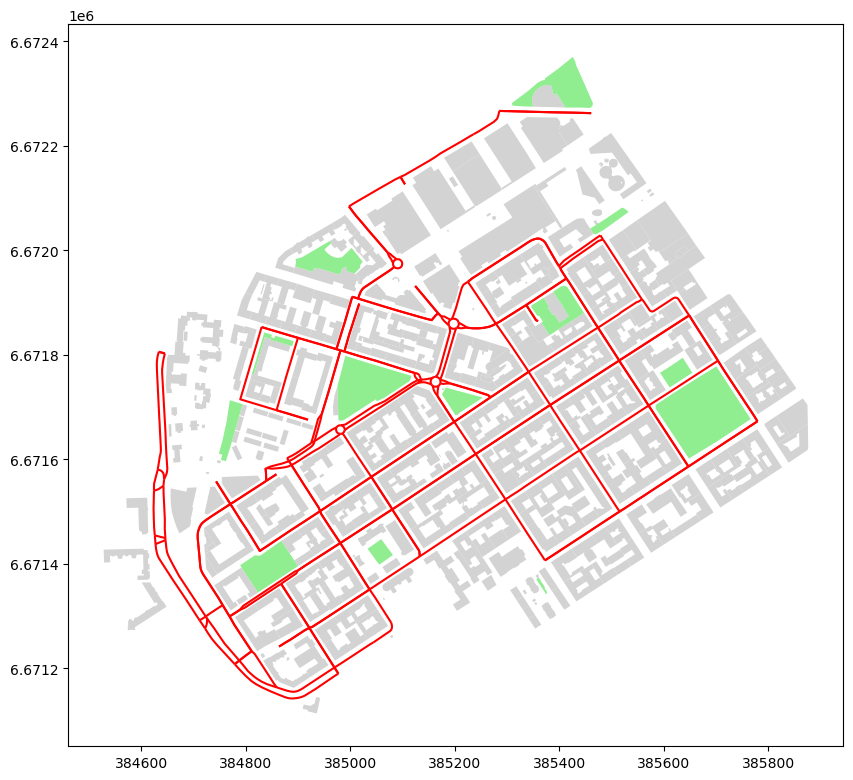

In [18]:
ax = buildings.plot(color="lightgray", figsize=(10, 10))
ax = parks.plot(ax=ax, color="lightgreen")
ax = roads.plot(ax=ax, color="red");

In [19]:
nearest_parks = buildings.sjoin_nearest(
    parks, distance_col="distance"
)
print(nearest_parks[:5], nearest_parks[-5:])
print(nearest_parks.shape)
print(nearest_parks.columns)

    osmid_left building              name_left  \
0  11711721042      yes  Nice Bike Pyörähuolto   
1      8035238   public            Lasipalatsi   
2      8042297      yes     Radisson Blu Royal   
3     14797170   school                   None   
4     14797171      yes                   None   

                                            geometry  index_right  \
0                     POINT (384966.661 6671503.786)           12   
1  POLYGON ((385459.65 6672184.469, 385456.356 66...            1   
2  POLYGON ((385104.154 6671916.693, 385101.584 6...            8   
3  POLYGON ((384815.326 6671762.71, 384815.792 66...            5   
4  POLYGON ((384797.759 6671853.253, 384798.253 6...            5   

   osmid_right leisure                name_right    distance  
0   1227991181    park  Kaartin lasaretin puisto  100.208527  
1      8042613    park            Simonpuistikko   16.284929  
2     37390082    park                      None   40.039501  
3     26999855    park          

In [20]:
print(f"Maximum distance: {nearest_parks["distance"].max().round(0)}")
print(f"Average distance: {nearest_parks["distance"].mean().round(0)}")

Maximum distance: 229.0
Average distance: 61.0


> Nearest road

In [21]:
nearest_roads = buildings.sjoin_nearest(roads, distance_col="distance")
print(nearest_roads[:5])

    osmid_left building              name_left  \
0  11711721042      yes  Nice Bike Pyörähuolto   
0  11711721042      yes  Nice Bike Pyörähuolto   
1      8035238   public            Lasipalatsi   
1      8035238   public            Lasipalatsi   
2      8042297      yes     Radisson Blu Royal   

                                            geometry  index_right  \
0                     POINT (384966.661 6671503.786)          182   
0                     POINT (384966.661 6671503.786)           24   
1  POLYGON ((385459.65 6672184.469, 385456.356 66...           33   
1  POLYGON ((385459.65 6672184.469, 385456.356 66...           15   
2  POLYGON ((385104.154 6671916.693, 385101.584 6...           83   

                                         osmid_right    name_right  \
0       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
0       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
1  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
1  [

> Combine with all roads

In [22]:
nearest_roads = nearest_roads.merge(
    roads[["geometry"]], left_on="index_right", right_index=True
)
print(nearest_roads[:3])
print(nearest_roads.columns)

    osmid_left building              name_left  \
0  11711721042      yes  Nice Bike Pyörähuolto   
0  11711721042      yes  Nice Bike Pyörähuolto   
1      8035238   public            Lasipalatsi   

                                          geometry_x  index_right  \
0                     POINT (384966.661 6671503.786)          182   
0                     POINT (384966.661 6671503.786)           24   
1  POLYGON ((385459.65 6672184.469, 385456.356 66...           33   

                                         osmid_right    name_right  \
0       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
0       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
1  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   

       highway   distance                                         geometry_y  
0  residential  11.181066  LINESTRING (385040.141 6671566.384, 385034.832...  
0  residential  11.181066  LINESTRING (384942.149 6671500.856, 384950.743...  
1   

With a column for buildings (`geometry_x`) and roads (`geometry_y`), use `shapely.shortest_line()` to create the LineStrings. The same conversion from geometry to array is necessary.

In [23]:
from shapely import shortest_line

connectors = nearest_roads.apply(
    lambda row: shortest_line(row["geometry_x"], row["geometry_y"]), axis=1
)
connectors = gpd.GeoDataFrame({"geometry": connectors}, crs=roads.crs)
connectors["distance"] = connectors.length
print(connectors[:5])

                                            geometry   distance
0  LINESTRING (384966.661 6671503.786, 384960.444...  11.181066
0  LINESTRING (384966.661 6671503.786, 384960.444...  11.181066
1  LINESTRING (385487.966 6672217.975, 385460.972...  52.015824
1  LINESTRING (385487.966 6672217.975, 385460.972...  52.015824
2  LINESTRING (385050.507 6671936.92, 385046.795 ...   6.659959


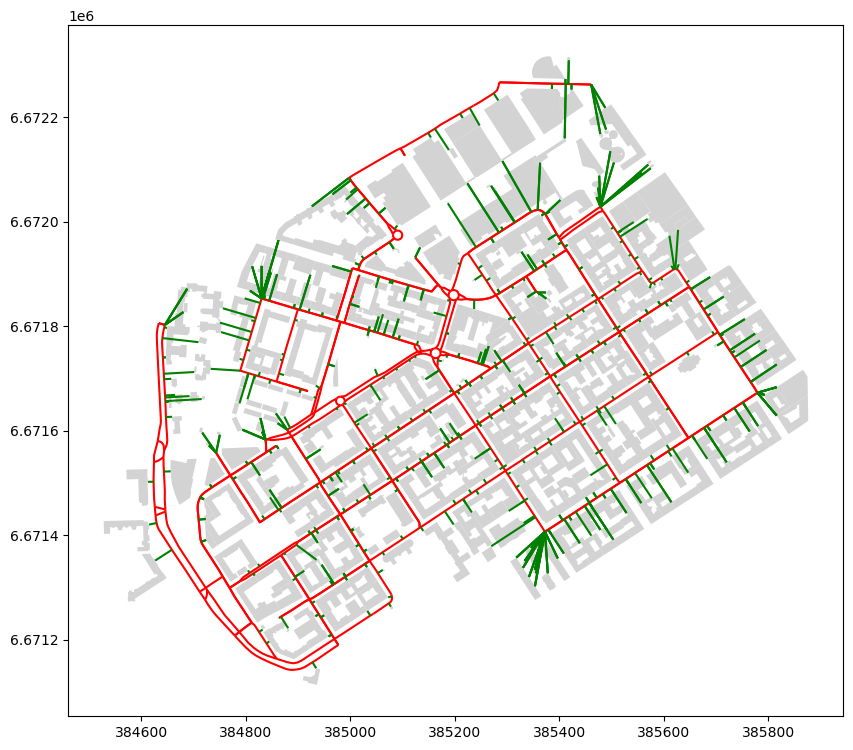

In [24]:
ax = buildings.plot(color="lightgray", figsize=(10, 10))
ax = roads.plot(ax=ax, color="red")
ax = connectors.plot(ax=ax, color="green");

>Closest park to each building

In [25]:
nearest_park_buildings = buildings.sjoin_nearest(
    parks, distance_col="distance"
)
print(f"Maximum distance: {nearest_park_buildings["distance"].max().round(0)} meters")

Maximum distance: 229.0 meters


In [26]:
nearest_park_buildings = nearest_park_buildings.merge(
    parks[["geometry"]], left_on="index_right", right_index=True
)
print(nearest_park_buildings[:3])

    osmid_left building              name_left  \
0  11711721042      yes  Nice Bike Pyörähuolto   
1      8035238   public            Lasipalatsi   
2      8042297      yes     Radisson Blu Royal   

                                          geometry_x  index_right  \
0                     POINT (384966.661 6671503.786)           12   
1  POLYGON ((385459.65 6672184.469, 385456.356 66...            1   
2  POLYGON ((385104.154 6671916.693, 385101.584 6...            8   

   osmid_right leisure                name_right    distance  \
0   1227991181    park  Kaartin lasaretin puisto  100.208527   
1      8042613    park            Simonpuistikko   16.284929   
2     37390082    park                      None   40.039501   

                                          geometry_y  
0  POLYGON ((385032.97 6671428.653, 385036.724 66...  
1  POLYGON ((385532.543 6672073.355, 385490.887 6...  
2  POLYGON ((384895.92 6671976.166, 384895.842 66...  


In [27]:
park_connectors = nearest_park_buildings.apply(
    lambda row: shortest_line(row["geometry_x"], row["geometry_y"]), axis=1
)

# Create a new GeoDataFrame out of these geometries
park_connectors = gpd.GeoDataFrame({"geometry": park_connectors}, crs=parks.crs)
print(park_connectors[:5])

                                            geometry
0  LINESTRING (384966.661 6671503.786, 385032.97 ...
1  LINESTRING (385522.671 6672097.702, 385519.92 ...
2  LINESTRING (385031.825 6671923.253, 385008.183...
3  LINESTRING (384815.326 6671762.71, 384815.326 ...
4  LINESTRING (384810.412 6671811.499, 384824.667...


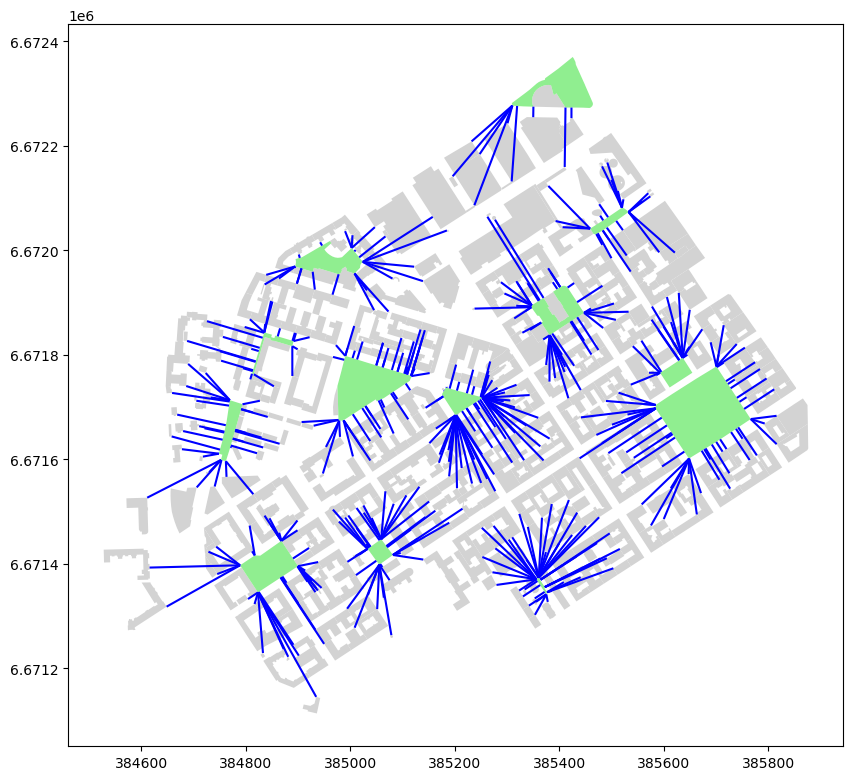

In [28]:
ax = buildings.plot(color="lightgray", figsize=(10, 10))
ax = parks.plot(ax=ax, color="lightgreen")
ax = park_connectors.plot(ax=ax, color="blue");

# K-Nearest Neighbor

The `R-Tree` spatial index can only do nearest neighbor. For K-nearest we use `KD-Tree` with `scipy`.

In [29]:
import geopandas as gpd 
stops = gpd.read_file("data/ch6/Helsinki/pt_stops_helsinki.gpkg").to_crs(3067)
building_points = gpd.read_file(
    "data/ch6/Helsinki/building_points_helsinki.zip"
).to_crs(3067)

print(building_points[:2])

          name                        geometry
0         None    POINT (381166.6 6676424.438)
1  Uimastadion  POINT (385236.565 6674238.472)


In [30]:
print(stops[:2])

     stop_name  stop_lat  stop_lon  stop_id                        geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (386623.301 6672037.884)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (386623.991 6672239.572)


In [31]:
print(stops.shape)
print(building_points.shape)

(8377, 5)
(158731, 2)


In [32]:
building_coords = building_points.get_coordinates().to_numpy() 
stop_coords = stops.get_coordinates().to_numpy() 
print(stop_coords[:5])

[[ 386623.30055697 6672037.88387715]
 [ 386623.99053928 6672239.57164472]
 [ 386629.00011373 6672130.5382358 ]
 [ 386627.61747966 6672385.44779099]
 [ 386619.37891936 6672431.39385187]]


>Create the KDTree

In [33]:
from scipy.spatial import KDTree

stop_kdt = KDTree(stop_coords)
stop_kdt

use `.query()`

In [34]:
k_nearest_dist, k_nearest_ix = stop_kdt.query(building_coords, k=3)
print(k_nearest_dist[:5])

[[ 92.67989301 461.43820422 466.16915044]
 [400.24336963 409.49707253 410.06137016]
 [109.81963349 130.59749777 133.6424814 ]
 [104.63243409 137.70639146 377.33198531]
 [472.24828173 519.68553375 551.35877795]]


In [35]:
print(k_nearest_ix[:5])

[[1131 1135 1125]
 [ 467  465  475]
 [  61   64   13]
 [ 532  533  506]
 [ 496  497  498]]


In [36]:
k_nearest_ix.T

array([[1131,  467,   61, ..., 4655, 4624, 4665],
       [1135,  465,   64, ..., 4678, 4625, 4617],
       [1125,  475,   13, ..., 4614, 4680, 4619]])

In [37]:
# Make a copy
k_nearest = building_points.copy()

# Add indices of nearest stops
k_nearest["1st_nearest_idx"] = k_nearest_ix.T[0]
k_nearest["2nd_nearest_idx"] = k_nearest_ix.T[1]
k_nearest["3rd_nearest_idx"] = k_nearest_ix.T[2]

# Add distances
k_nearest["1st_nearest_dist"] = k_nearest_dist.T[0]
k_nearest["2nd_nearest_dist"] = k_nearest_dist.T[1]
k_nearest["3rd_nearest_dist"] = k_nearest_dist.T[2]

In [38]:
print(k_nearest[:5])

             name                        geometry  1st_nearest_idx  \
0            None    POINT (381166.6 6676424.438)             1131   
1     Uimastadion  POINT (385236.565 6674238.472)              467   
2            None  POINT (386317.478 6672100.648)               61   
3  Hartwall Arena   POINT (385225.109 6676120.56)              532   
4           Talli  POINT (385079.733 6676989.745)              496   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   
2               64               13        109.819633        130.597498   
3              533              506        104.632434        137.706391   
4              497              498        472.248282        519.685534   

   3rd_nearest_dist  
0        466.169150  
1        410.061370  
2        133.642481  
3        377.331985  
4        551.35877

In [39]:
stops["stop_index"] = stops.index

In [40]:
k_nearest_1 = k_nearest.merge(
    stops[["stop_index", "geometry"]], 
    left_on="1st_nearest_idx", 
    right_on="stop_index", 
    suffixes=("", "_knearest")
)
print(k_nearest_1[:2])

          name                        geometry  1st_nearest_idx  \
0         None    POINT (381166.6 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   

   3rd_nearest_dist  stop_index               geometry_knearest  
0         466.16915        1131   POINT (381256.66 6676446.317)  
1         410.06137         467  POINT (384973.331 6674539.973)  


In [41]:
k_nearest_2 = k_nearest.merge(
    stops[["stop_index", "geometry"]], 
    left_on="2nd_nearest_idx", 
    right_on="stop_index", 
    suffixes=("", "_knearest")
)
print(k_nearest_2[:2])

k_nearest_3 = k_nearest.merge(
    stops[["stop_index", "geometry"]], 
    left_on="3rd_nearest_idx", 
    right_on="stop_index", 
    suffixes=("", "_knearest")
)
print(k_nearest_3[:2])

          name                        geometry  1st_nearest_idx  \
0         None    POINT (381166.6 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   

   3rd_nearest_dist  stop_index               geometry_knearest  
0         466.16915        1135  POINT (381625.316 6676474.488)  
1         410.06137         465  POINT (385270.775 6674646.538)  
          name                        geometry  1st_nearest_idx  \
0         None    POINT (381166.6 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465    

>Create the LineStrings

In [42]:
from shapely import LineString

k_nearest_1["geometry"] = k_nearest_1.apply(
    lambda row: LineString([row["geometry"], row["geometry_knearest"]]), axis=1
)
k_nearest_2["geometry"] = k_nearest_2.apply(
    lambda row: LineString([row["geometry"], row["geometry_knearest"]]), axis=1
)
k_nearest_3["geometry"] = k_nearest_3.apply(
    lambda row: LineString([row["geometry"], row["geometry_knearest"]]), axis=1
)
print(k_nearest_1[:2])

          name                                           geometry  \
0         None  LINESTRING (381166.6 6676424.438, 381256.66 66...   
1  Uimastadion  LINESTRING (385236.565 6674238.472, 384973.331...   

   1st_nearest_idx  2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  \
0             1131             1135             1125         92.679893   
1              467              465              475        400.243370   

   2nd_nearest_dist  3rd_nearest_dist  stop_index  \
0        461.438204         466.16915        1131   
1        409.497073         410.06137         467   

                geometry_knearest  
0   POINT (381256.66 6676446.317)  
1  POINT (384973.331 6674539.973)  


>choose a building from the names

In [43]:
k_nearest.name.unique()

array([None, 'Uimastadion', 'Hartwall Arena', ..., 'Peltolan koulu',
       'Hilton Helsinki Airport', 'Posti Oy Logistiikkakeskus'],
      dtype=object)

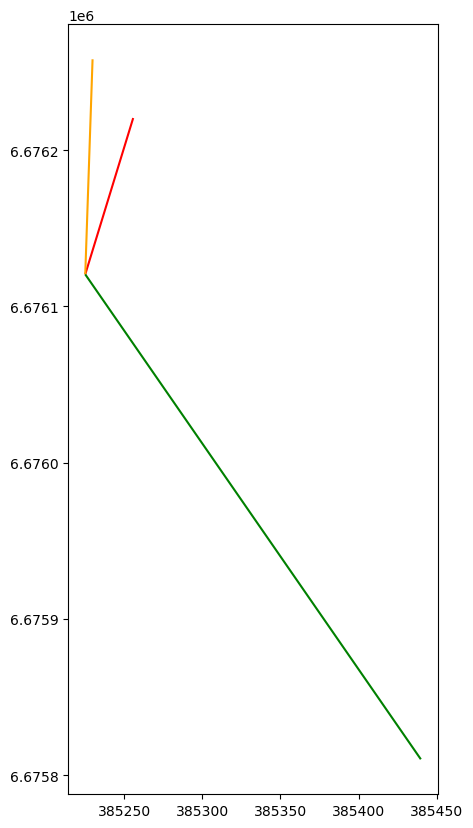

In [44]:
selected_name = "Hartwall Arena"
ax = k_nearest_1.loc[k_nearest_1["name"] == selected_name].plot(figsize=(10,10), color="red")
ax = k_nearest_2.loc[k_nearest_2["name"] == selected_name].plot(ax=ax, color="orange")
ax = k_nearest_3.loc[k_nearest_3["name"] == selected_name].plot(ax=ax, color="green");

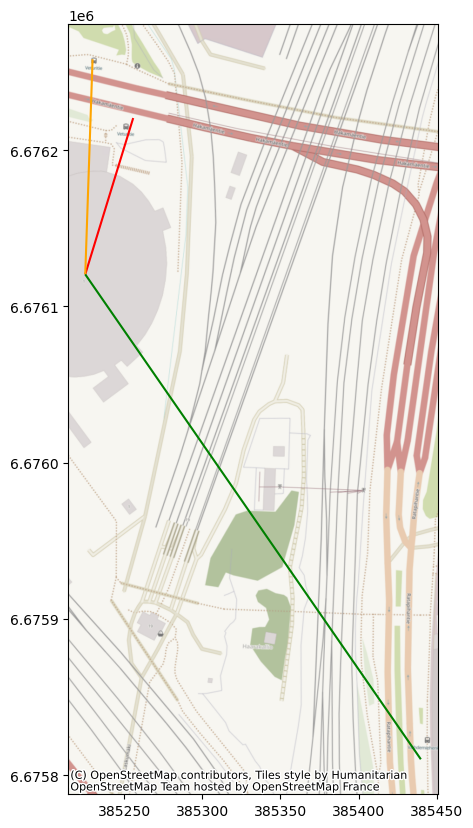

In [45]:
import contextily as cx
selected_name = "Hartwall Arena"
ax = k_nearest_1.loc[k_nearest_1["name"] == selected_name].plot(figsize=(10,10), color="red")
ax = k_nearest_2.loc[k_nearest_2["name"] == selected_name].plot(ax=ax, color="orange")
ax = k_nearest_3.loc[k_nearest_3["name"] == selected_name].plot(ax=ax, color="green")
cx.add_basemap(ax, crs=k_nearest.crs);

# Nearest neighbors within radius

- uses `KDTree` index for both datasets
- use `query_ball_tree` to find nearest neighbors

Find all buildings within 200m of the stops

In [58]:
from scipy.spatial import KDTree

stop_kdt = KDTree(stop_coords)
building_kdt = KDTree(building_coords)

k_nearest_ix = stop_kdt.query_ball_tree(building_kdt, r=200)

In [59]:
len(k_nearest_ix)

8377

In [61]:
k_nearest_ix[0][:10]

[1129, 1130, 1155, 2054, 2055, 2056, 2057, 2058, 2059, 9910]

In [62]:
stops["building_ids_within_range"] = k_nearest_ix
print(stops.head())
print(stops.columns)

     stop_name   stop_lat   stop_lon  stop_id                        geometry  \
0  Ritarihuone  60.169460  24.956670  1010102  POINT (386623.301 6672037.884)   
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (386623.991 6672239.572)   
2   Kirkkokatu  60.170293  24.956721  1010104      POINT (386629 6672130.538)   
3    Vironkatu  60.172580  24.956554  1010105  POINT (386627.617 6672385.448)   
4    Vironkatu  60.172990  24.956380  1010106  POINT (386619.379 6672431.394)   

   stop_index                          building_ids_within_range  
0           0  [1129, 1130, 1155, 2054, 2055, 2056, 2057, 205...  
1           1  [1130, 2054, 2055, 2057, 2058, 2059, 2066, 206...  
2           2  [1129, 1130, 2054, 2055, 2056, 2057, 2058, 205...  
3           3  [2060, 2062, 2063, 2064, 2065, 2066, 2067, 206...  
4           4  [1136, 2060, 2061, 2062, 2063, 2064, 2065, 206...  
Index(['stop_name', 'stop_lat', 'stop_lon', 'stop_id', 'geometry',
       'stop_index', 'building_ids_within_ra

>Calculate the number of buildings within 200m of each stop

In [63]:
stops["building_cnt"] = stops["building_ids_within_range"].apply(
    lambda id_list: len(id_list)
)
print(stops.head())

     stop_name   stop_lat   stop_lon  stop_id                        geometry  \
0  Ritarihuone  60.169460  24.956670  1010102  POINT (386623.301 6672037.884)   
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (386623.991 6672239.572)   
2   Kirkkokatu  60.170293  24.956721  1010104      POINT (386629 6672130.538)   
3    Vironkatu  60.172580  24.956554  1010105  POINT (386627.617 6672385.448)   
4    Vironkatu  60.172990  24.956380  1010106  POINT (386619.379 6672431.394)   

   stop_index                          building_ids_within_range  building_cnt  
0           0  [1129, 1130, 1155, 2054, 2055, 2056, 2057, 205...            50  
1           1  [1130, 2054, 2055, 2057, 2058, 2059, 2066, 206...            69  
2           2  [1129, 1130, 2054, 2055, 2056, 2057, 2058, 205...            56  
3           3  [2060, 2062, 2063, 2064, 2065, 2066, 2067, 206...            74  
4           4  [1136, 2060, 2061, 2062, 2063, 2064, 2065, 206...            78  


In [64]:
print("Max number of buildings:", stops["building_cnt"].max())
print("Average number of buildings:", stops["building_cnt"].mean().round(1))

Max number of buildings: 181
Average number of buildings: 32.2


>Take a look at the densest neighborhoods

In [65]:
filtered = stops["building_cnt"] == stops["building_cnt"].max()
building_ids = stops.loc[filtered].building_ids_within_range.values[0]

In [67]:
m = stops.loc[filtered].explore(
    tiles="CartoDB Positron", color="red", marker_kwds={"radius": 5}, max_zoom=16
)
building_points.loc[building_ids].explore(m=m)

>Find all buildings within 200 meters from transit stops

- Create 200m buffer around stops
- Make spatial join between buffers and building points

In [70]:
stop_buffer = stops.copy()

In [72]:
# Create the buffer
stop_buffer["geometry"] = stops.buffer(200)

In [73]:
# Find all building points intersecting the buffer 
buffer_buildings = stop_buffer.sjoin(
    building_points, predicate="intersects"
)

In [74]:
# Calculate the number of buildings per stop 
building_count = (
    buffer_buildings
    .groupby("stop_id")
    .stop_name.count()
    .to_frame().reset_index()
)

In [75]:
# Rename stop_name column
building_count = building_count.rename(
    columns={"stop_name": "building_cnt_buffer"}
)

In [76]:
# Join information into the stops 
stop_buffer = stop_buffer.merge(building_count, on="stop_id")

In [77]:
print(stop_buffer.head())

     stop_name   stop_lat   stop_lon  stop_id  \
0  Ritarihuone  60.169460  24.956670  1010102   
1   Kirkkokatu  60.171270  24.956570  1010103   
2   Kirkkokatu  60.170293  24.956721  1010104   
3    Vironkatu  60.172580  24.956554  1010105   
4    Vironkatu  60.172990  24.956380  1010106   

                                            geometry  stop_index  \
0  POLYGON ((386823.301 6672037.884, 386822.338 6...           0   
1  POLYGON ((386823.991 6672239.572, 386823.027 6...           1   
2  POLYGON ((386829 6672130.538, 386828.037 66721...           2   
3  POLYGON ((386827.617 6672385.448, 386826.654 6...           3   
4  POLYGON ((386819.379 6672431.394, 386818.416 6...           4   

                           building_ids_within_range  building_cnt  \
0  [1129, 1130, 1155, 2054, 2055, 2056, 2057, 205...            50   
1  [1130, 2054, 2055, 2057, 2058, 2059, 2066, 206...            69   
2  [1129, 1130, 2054, 2055, 2056, 2057, 2058, 205...            56   
3  [2060, 2062, 